In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv(
    "outputs/step2_final/combined_district_monthly_indicators_final.csv"
)


In [25]:
stable_df = df[~df["low_volume_flag"]].copy()


In [26]:
global_stats = stable_df[[
    "update_pressure_index",
    "identity_volatility_ratio",
    "biometric_alignment_score"
]].describe(percentiles=[0.75, 0.9, 0.95])

global_stats


,update_pressure_index,identity_volatility_ratio,biometric_alignment_score
count,4506.000000,4506.000000,4506.000000
mean,24.748824,10.824024,1884.712662
std,73.242206,41.473160,3544.371960
min,0.000000,0.000000,0.000000
50%,13.403540,5.882358,594.291667
75%,22.998813,10.215389,1840.200000
90%,39.995353,17.223979,5118.000000
95%,61.508661,24.765169,8619.750000
max,2700.553191,1599.297872,37932.000000


### INSIGHT 1 — Migration Pressure Zones
Districts in the top 5% of update pressure
→ sustained migration / address churn

In [27]:
pressure_by_district = (
    stable_df
    .groupby(["state", "district"])["update_pressure_index"]
    .mean()
)

threshold_pressure = pressure_by_district.quantile(0.95)

migration_pressure_zones = pressure_by_district[
    pressure_by_district >= threshold_pressure
].sort_values(ascending=False)

migration_pressure_zones


state           district                    
Maharashtra     Thane                           320.254725
Delhi           North West Delhi                258.667803
Maharashtra     Pune                            215.616773
Uttar Pradesh   Gorakhpur                       145.389006
                Bulandshahr                     139.263327
Bihar           Muzaffarpur                     129.627232
                Patna                           124.247352
Jharkhand       Deoghar                         121.923354
Bihar           Bhagalpur                       119.027958
Punjab          Amritsar                        117.595661
Maharashtra     Parbhani                        113.410291
Gujarat         Ahmedabad                       112.222065
                Vadodara                        101.723313
Kerala          Thrissur                        101.034562
Gujarat         Kachchh                         100.625334
Tamil Nadu      Madurai                          99.667863
Kerala     

### INSIGHT 2 — Identity Volatility Hotspots
Top 5% districts by identity volatility

In [28]:
volatility_by_district = (
    stable_df
    .groupby(["state", "district"])["identity_volatility_ratio"]
    .mean()
)

threshold_volatility = volatility_by_district.quantile(0.95)

identity_volatility_hotspots = volatility_by_district[
    volatility_by_district >= threshold_volatility
].sort_values(ascending=False)

identity_volatility_hotspots


state           district                    
Maharashtra     Thane                           185.716841
Delhi           North West Delhi                149.666466
Uttar Pradesh   Gorakhpur                        94.394076
                Bulandshahr                      85.804291
Jharkhand       Deoghar                          83.621370
Bihar           Muzaffarpur                      75.398217
                Bhagalpur                        70.624628
                Patna                            70.115945
Chhattisgarh    Mohla-Manpur-Ambagarh Chouki     61.438366
Uttarakhand     Haridwar                         54.733980
Manipur         Thoubal                          50.392333
Uttar Pradesh   Mathura                          48.158205
Chhattisgarh    Raipur                           46.567580
Manipur         Imphal East                      46.120139
Assam           Nagaon                           44.923607
Punjab          Amritsar                         44.917033
Rajasthan  

### INSIGHT 3 — Aadhaar Maintenance-Dominated Districts
High update pressure AND
Low enrolment relative to peers

In [29]:
maintenance_districts = stable_df[
    (stable_df["update_pressure_index"] >= threshold_pressure) &
    (stable_df["total_enrolment"] < stable_df["total_enrolment"].quantile(0.25))
][["state", "district", "year_month", "update_pressure_index", "total_enrolment"]]

maintenance_districts.sort_values(
    by="update_pressure_index",
    ascending=False
)


,state,district,year_month,update_pressure_index,total_enrolment
2714,Maharashtra,Thane,2025-03,2700.553191,47
1071,Delhi,North West Delhi,2025-03,1901.700000,60
4239,Uttar Pradesh,Gorakhpur,2025-03,1171.133333,60
2662,Maharashtra,Pune,2025-04,1105.956522,69
706,Bihar,Muzaffarpur,2025-03,1068.729730,74
...,...,...,...,...,...
2834,Meghalaya,Ri Bhoi,2025-03,57.164179,67
4757,West Bengal,Nadia,2025-04,57.016129,248
4317,Uttar Pradesh,Kaushambi,2025-04,56.520599,267
303,Assam,Barpeta,2025-04,55.669767,215


### INSIGHT 4 — Administrative Shock Events
Sudden month-to-month pressure jumps
(Top 1% change events)

In [30]:
stable_df = stable_df.sort_values(
    by=["state", "district", "year_month"]
)

stable_df["pressure_change"] = (
    stable_df
    .groupby(["state", "district"])["log_update_pressure"]
    .diff()
)

shock_threshold = stable_df["pressure_change"].quantile(0.99)

administrative_shocks = stable_df[
    stable_df["pressure_change"] >= shock_threshold
][["state", "district", "year_month", "pressure_change"]]

administrative_shocks.sort_values(
    by="pressure_change",
    ascending=False
)


,state,district,year_month,pressure_change
729,Bihar,Pashchim Champaran,2025-09,2.718101
3475,Rajasthan,Jaipur,2025-05,2.635434
1129,Gujarat,Ahmadabad,2025-09,2.373556
1050,Delhi,New Delhi,2025-09,2.244859
3752,Tamil Nadu,Thiruvallur,2025-09,2.113548
1360,Gujarat,Surendranagar,2025-09,2.102609
601,Bihar,Bhagalpur,2025-07,2.013630
387,Assam,Goalpara,2025-06,1.968293
560,Bihar,Araria,2025-07,1.942012
295,Assam,Baksa,2025-05,1.883478


### INSIGHT 5 — Chronic Structural Stress Districts
Districts simultaneously:

Top 10% pressure

Top 10% volatility

Across entire period

In [31]:
district_means = (
    stable_df
    .groupby(["state", "district"])[
        ["update_pressure_index", "identity_volatility_ratio"]
    ]
    .mean()
)

pressure_cutoff = district_means["update_pressure_index"].quantile(0.90)
volatility_cutoff = district_means["identity_volatility_ratio"].quantile(0.90)

chronic_stress_districts = district_means[
    (district_means["update_pressure_index"] >= pressure_cutoff) &
    (district_means["identity_volatility_ratio"] >= volatility_cutoff)
].sort_values(
    by=["update_pressure_index", "identity_volatility_ratio"],
    ascending=False
)

chronic_stress_districts


update_pressure_index  \
state          district                                              
Maharashtra    Thane                                    320.254725   
Delhi          North West Delhi                         258.667803   
Maharashtra    Pune                                     215.616773   
Uttar Pradesh  Gorakhpur                                145.389006   
               Bulandshahr                              139.263327   
Bihar          Muzaffarpur                              129.627232   
               Patna                                    124.247352   
Jharkhand      Deoghar                                  121.923354   
Bihar          Bhagalpur                                119.027958   
Punjab         Amritsar                                 117.595661   
Maharashtra    Parbhani                                 113.410291   
Gujarat        Ahmedabad                                112.222065   
               Vadodara                                 101.723313   
               Kachchh                                  100.625334   
Uttarakhand    Haridwar                                  92.666300   
Rajasthan      Sikar                                     90.417142   
Chhattisgarh   Raipur                                    87.643676   
Uttar Pradesh  Mathura                                   77.596173   
Assam          Nagaon                                    76.616867   
Manipur        Thoubal                                   75.164570   
Uttar Pradesh  Lucknow                                   74.346060   
Maharashtra    Chandrapur                                72.456289   
Manipur        Imphal East                               70.239523   
Uttar Pradesh  Banda                                     65.952566   
Chhattisgarh   Mohla-Manpur-Ambagarh Chouki              65.555351   
Maharashtra    Gadchiroli                                64.422899   
Rajasthan      Kota                                      62.482224   
Maharashtra    Yavatmal                                  61.708153   
Manipur        Imphal West                               61.252027   
Andhra Pradesh Warangal                                  60.548540   
Punjab         Ludhiana                                  59.399972   
Delhi          South Delhi                               57.651642   
Andhra Pradesh Adilabad                                  55.909153   
Rajasthan      Jaipur                                    55.152548   
Assam          Barpeta                                   53.538010   
Andhra Pradesh Khammam                                   53.487586   
               Nalgonda                                  52.906994   
Chandigarh     Chandigarh                                52.535110   
Maharashtra    Buldana                                   48.762836   
               Ratnagiri                                 48.371682   
               Bhandara                                  47.363125   
Manipur        Bishnupur                                 47.098601   
Maharashtra    Osmanabad                                 46.847741   
Uttarakhand    Nainital                                  46.117692   
Maharashtra    Sindhudurg                                45.583022   
Madhya Pradesh Katni                                     45.487359   
Chhattisgarh   Sarangarh-Bilaigarh                       45.486422   
Delhi          West Delhi                                43.915611   
Uttar Pradesh  Jaunpur                                   43.167440   
Haryana        Faridabad                                 42.941166   
Bihar          Madhubani                                 42.347738   
Uttar Pradesh  Kanpur Nagar                              41.763703   
Delhi          Central Delhi                             41.130534   
Uttar Pradesh  Unnao                                     39.922343   
Uttarakhand    Dehradun                                  39.860005   
Delhi          South West Delhi                        

### top 15 districts for each insight

In [32]:
migration_pressure_top15 = (
    migration_pressure_zones
    .sort_values(ascending=False)
    .head(15)
)

migration_pressure_top15


state          district        
Maharashtra    Thane               320.254725
Delhi          North West Delhi    258.667803
Maharashtra    Pune                215.616773
Uttar Pradesh  Gorakhpur           145.389006
               Bulandshahr         139.263327
Bihar          Muzaffarpur         129.627232
               Patna               124.247352
Jharkhand      Deoghar             121.923354
Bihar          Bhagalpur           119.027958
Punjab         Amritsar            117.595661
Maharashtra    Parbhani            113.410291
Gujarat        Ahmedabad           112.222065
               Vadodara            101.723313
Kerala         Thrissur            101.034562
Gujarat        Kachchh             100.625334
Name: update_pressure_index, dtype: float64

In [33]:
identity_volatility_top15 = (
    identity_volatility_hotspots
    .sort_values(ascending=False)
    .head(15)
)

identity_volatility_top15


state          district                    
Maharashtra    Thane                           185.716841
Delhi          North West Delhi                149.666466
Uttar Pradesh  Gorakhpur                        94.394076
               Bulandshahr                      85.804291
Jharkhand      Deoghar                          83.621370
Bihar          Muzaffarpur                      75.398217
               Bhagalpur                        70.624628
               Patna                            70.115945
Chhattisgarh   Mohla-Manpur-Ambagarh Chouki     61.438366
Uttarakhand    Haridwar                         54.733980
Manipur        Thoubal                          50.392333
Uttar Pradesh  Mathura                          48.158205
Chhattisgarh   Raipur                           46.567580
Manipur        Imphal East                      46.120139
Assam          Nagaon                           44.923607
Name: identity_volatility_ratio, dtype: float64

In [34]:
maintenance_top15 = (
    maintenance_districts
    .sort_values("update_pressure_index", ascending=False)
    .head(15)
)

maintenance_top15


,state,district,year_month,update_pressure_index,total_enrolment
2714,Maharashtra,Thane,2025-03,2700.553191,47
1071,Delhi,North West Delhi,2025-03,1901.700000,60
4239,Uttar Pradesh,Gorakhpur,2025-03,1171.133333,60
2662,Maharashtra,Pune,2025-04,1105.956522,69
706,Bihar,Muzaffarpur,2025-03,1068.729730,74
733,Bihar,Patna,2025-03,960.850000,80
597,Bihar,Bhagalpur,2025-03,952.112676,71
4149,Uttar Pradesh,Bulandshahr,2025-03,942.704918,61
3231,Punjab,Amritsar,2025-03,793.224490,49
1675,Jharkhand,Deoghar,2025-03,683.854545,55


In [35]:
administrative_shocks_top15 = (
    administrative_shocks
    .sort_values("pressure_change", ascending=False)
    .head(15)
)

administrative_shocks_top15


,state,district,year_month,pressure_change
729,Bihar,Pashchim Champaran,2025-09,2.718101
3475,Rajasthan,Jaipur,2025-05,2.635434
1129,Gujarat,Ahmadabad,2025-09,2.373556
1050,Delhi,New Delhi,2025-09,2.244859
3752,Tamil Nadu,Thiruvallur,2025-09,2.113548
1360,Gujarat,Surendranagar,2025-09,2.102609
601,Bihar,Bhagalpur,2025-07,2.013630
387,Assam,Goalpara,2025-06,1.968293
560,Bihar,Araria,2025-07,1.942012
295,Assam,Baksa,2025-05,1.883478


In [36]:
chronic_stress_top15 = (
    chronic_stress_districts
    .sort_values(
        by=["update_pressure_index", "identity_volatility_ratio"],
        ascending=False
    )
    .head(15)
)

chronic_stress_top15


update_pressure_index  \
state         district                                  
Maharashtra   Thane                        320.254725   
Delhi         North West Delhi             258.667803   
Maharashtra   Pune                         215.616773   
Uttar Pradesh Gorakhpur                    145.389006   
              Bulandshahr                  139.263327   
Bihar         Muzaffarpur                  129.627232   
              Patna                        124.247352   
Jharkhand     Deoghar                      121.923354   
Bihar         Bhagalpur                    119.027958   
Punjab        Amritsar                     117.595661   
Maharashtra   Parbhani                     113.410291   
Gujarat       Ahmedabad                    112.222065   
              Vadodara                     101.723313   
              Kachchh                      100.625334   
Uttarakhand   Haridwar                      92.666300   

                                identity_volatility_ratio  
state         district                                     
Maharashtra   Thane                            185.716841  
Delhi         North West Delhi                 149.666466  
Maharashtra   Pune                              40.236653  
Uttar Pradesh Gorakhpur                         94.394076  
              Bulandshahr                       85.804291  
Bihar         Muzaffarpur                       75.398217  
              Patna                             70.115945  
Jharkhand     Deoghar                           83.621370  
Bihar         Bhagalpur                         70.624628  
Punjab        Amritsar                          44.917033  
Maharashtra   Parbhani                          41.720604  
Gujarat       Ahmedabad                         35.001294  
              Vadodara                          41.937692  
              Kachchh                           33.116076  
Uttarakhand   Haridwar                          54.733980

### Visulisation


In [37]:
mp_df = migration_pressure_top15.reset_index()
mp_df.columns = ["state", "district", "update_pressure_index"]


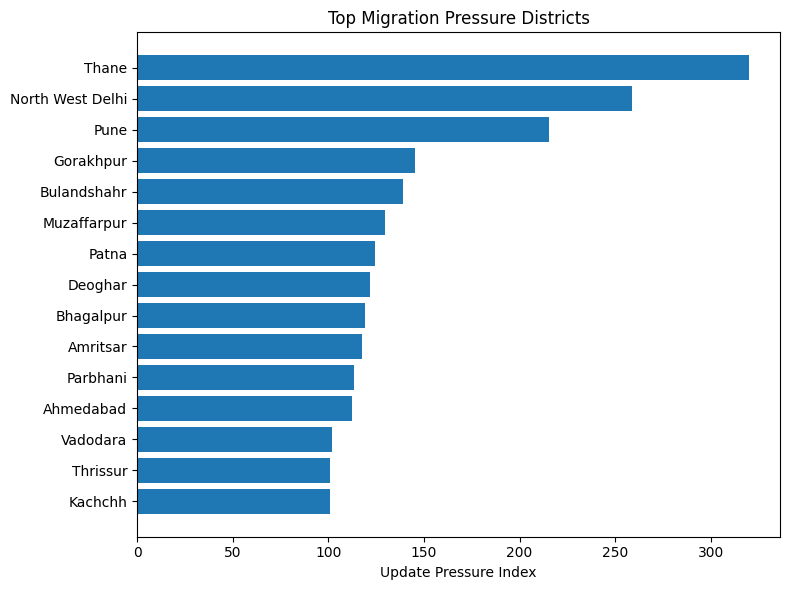

In [39]:
plt.figure(figsize=(8, 6))
plt.barh(
    mp_df["district"],
    mp_df["update_pressure_index"]
)

plt.xlabel("Update Pressure Index")
plt.title("Top Migration Pressure Districts")
plt.gca().invert_yaxis()  # highest on top
plt.tight_layout()
plt.show()

In [40]:
iv_df = identity_volatility_top15.reset_index()
iv_df.columns = ["state", "district", "identity_volatility_ratio"]


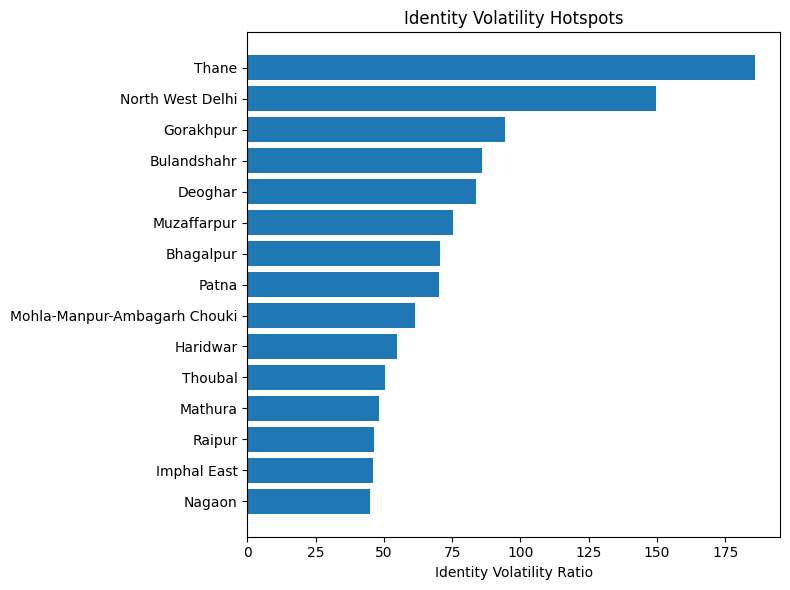

In [41]:
plt.figure(figsize=(8, 6))
plt.barh(
    iv_df["district"],
    iv_df["identity_volatility_ratio"]
)

plt.xlabel("Identity Volatility Ratio")
plt.title("Identity Volatility Hotspots")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [42]:
md_df = maintenance_top15.copy()


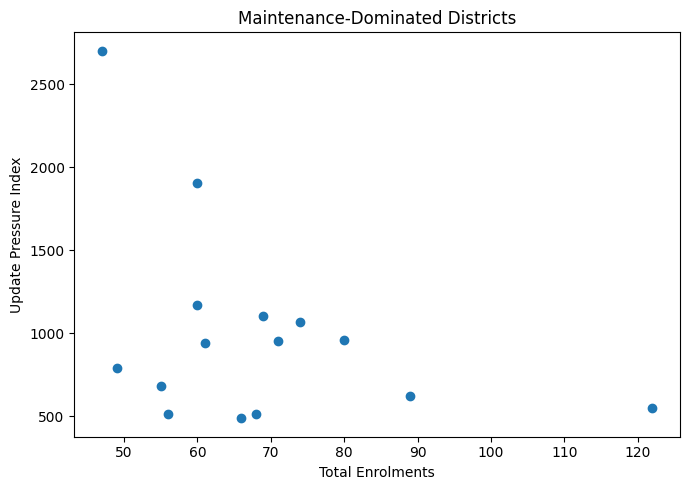

In [43]:
plt.figure(figsize=(7, 5))
plt.scatter(
    md_df["total_enrolment"],
    md_df["update_pressure_index"]
)

plt.xlabel("Total Enrolments")
plt.ylabel("Update Pressure Index")
plt.title("Maintenance-Dominated Districts")

plt.tight_layout()
plt.show()


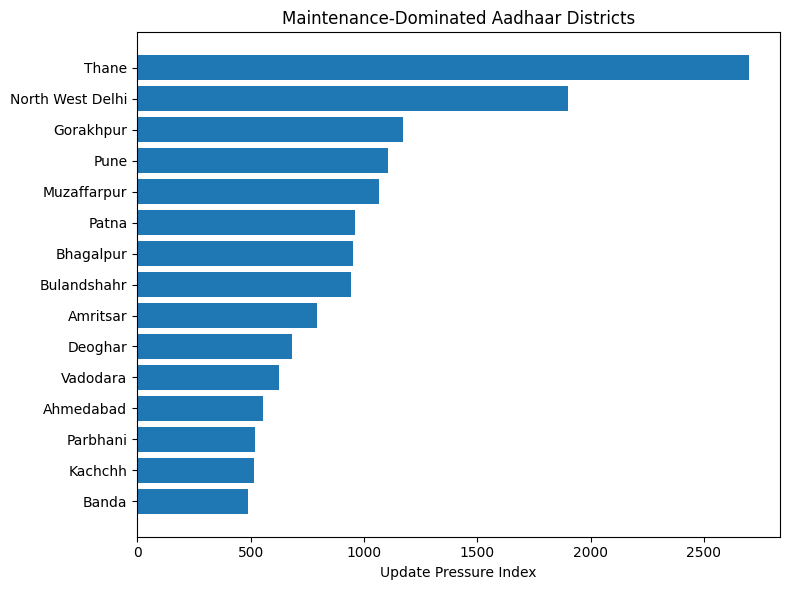

In [46]:
md_df = maintenance_top15.copy()
md_df = md_df.sort_values(
    by="update_pressure_index",
    ascending=False
)
plt.figure(figsize=(8, 6))
plt.barh(
    md_df["district"],
    md_df["update_pressure_index"]
)

plt.xlabel("Update Pressure Index")
plt.title("Maintenance-Dominated Aadhaar Districts")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
